In [8]:
%load_ext autoreload
%autoreload 2

from pps import PredatorPreySwarmEnv
import json
import matplotlib.pyplot as plt
import supersuit as ss
from stable_baselines3 import PPO, DDPG
from tqdm import tqdm

with open("config/eval_params.json") as f:
    config = json.load(f)

def display_results(results):
    num_subplots = len(results[0])
    fig, axs = plt.subplots(num_subplots, 1)
    fig.tight_layout()
    for i, metric in enumerate(results[0]):
        axs[i].set_ylim(0, 1.1)
        axs[i].plot([r[metric] for r in results])
        axs[i].set_title(metric)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_original_env(env):
    """Recursively unwrap the environment to get the original PettingZoo environment."""
    # Check if it's a ConcatVecEnv
    if hasattr(env, 'vec_envs'):
        # Assume only one environment was concatenated
        return get_original_env(env.vec_envs[0])
    # Check for other wrappers
    if hasattr(env, 'env'):
        return get_original_env(env.env)
    elif hasattr(env, 'venv'):
        return get_original_env(env.venv)
    # If no more wrappers, return the environment
    return env

In [57]:
# NO PRETRAINED MODEL
results = []
env = PredatorPreySwarmEnv(config, metrics_in_info=False)
max_ep_len = env._ep_len

obs, info = env.reset()
for _ in tqdm(range(max_ep_len), desc="Evaluationg episode"):
    # img = env.render(mode='rgb_array')
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}
    obs, rew, term, trunc, info = env.step(actions)
    # results.append(info[0])
env.close()


Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [04:10<00:00, 19.98it/s]


In [60]:
orig_env = get_original_env(env)
info = orig_env.compute_metrics()
# display_results(results)
print("Final results:", info)

# Final results: {'average_clustering': 0.022597336507346907, 'network_efficiency': 0.6268013468013466, 'density': 0.25636363636363635, 'modularity': 0.007285829869330504, 'average_degree_centrality': 0.25636363636363635}
# Final results: {'average_clustering': 0.10251758280967764, 'network_efficiency': 0.9612121212121212, 'density': 0.9224242424242424, 'modularity': -0.008603591248346691, 'average_degree_centrality': 0.9224242424242424}

Final results: {'average_clustering': 0.04076770937372443, 'network_efficiency': 0.864040404040404, 'density': 0.7280808080808081, 'modularity': -0.016845021514604527, 'average_degree_centrality': 0.7280808080808082, 'G': <networkx.classes.graph.Graph object at 0x00000226E3757D60>}


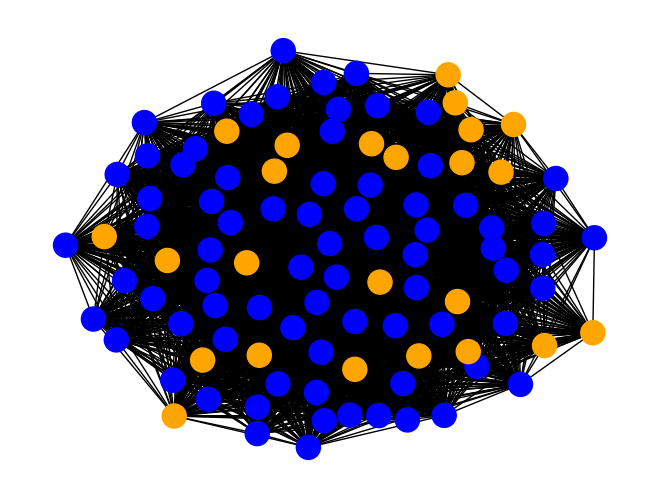

In [61]:
import networkx as nx
node_colors = ['orange' if info['G'].nodes[node]['infected'] else 'blue' for node in info['G'].nodes()]
nx.draw(info['G'], node_color=node_colors, with_labels=False)
plt.show()

In [9]:
differences = {
    'clustering': [],
    'modularity': [],
    'efficiency': []
}

num_experiments = 10
model = PPO.load("models/DecPenNewPPO", device="cpu")

for i in range(num_experiments):
    print("Experiment", i)
    # model = PPO.load("models/evade.zip")
    env = PredatorPreySwarmEnv(config, metrics_in_info=False, infect=False)
    max_ep_len = env._ep_len

    env = ss.pettingzoo_env_to_vec_env_v1(env)
    env = ss.concat_vec_envs_v1(env, 1, base_class="stable_baselines3")

    obs = env.reset()

    for _ in tqdm(range(max_ep_len), desc="Evaluationg episode"):
        # img = env.render(mode="rgb_array")
        action, _ = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        # print(info[0])
        # results2.append(info[0])


    orig_env = get_original_env(env)
    info_before = orig_env.par_env.compute_metrics()

    orig_env.par_env.infect()
    obs = env.reset()

    for _ in tqdm(range(max_ep_len), desc="Evaluationg episode"):
        # img = env.render(mode="rgb_array")
        action, _ = model.predict(obs)
        obs, rewards, dones, info = env.step(action)

    orig_env = get_original_env(env)
    info = orig_env.par_env.compute_metrics()
    env.close()

    differences['clustering'].append(info['average_clustering'] - info_before['average_clustering'])
    differences['modularity'].append(info['modularity'] - info_before['modularity'])
    differences['efficiency'].append(info['network_efficiency'] - info_before['network_efficiency'])

Experiment 0
Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:32<00:00, 23.58it/s]


Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:31<00:00, 23.69it/s]


Experiment 1
Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:29<00:00, 23.88it/s]


Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:28<00:00, 23.96it/s]


Experiment 2
Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:36<00:00, 23.05it/s]


Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:29<00:00, 23.85it/s]


Experiment 3
Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:28<00:00, 23.95it/s]


Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:29<00:00, 23.81it/s]


Experiment 4
Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:27<00:00, 24.08it/s]


Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:27<00:00, 24.08it/s]


Experiment 5
Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:27<00:00, 24.11it/s]


Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:30<00:00, 23.73it/s]


Experiment 6
Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:29<00:00, 23.83it/s]


Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:28<00:00, 24.01it/s]


Experiment 7
Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:28<00:00, 24.03it/s]


Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:28<00:00, 23.95it/s]


Experiment 8
Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:29<00:00, 23.92it/s]


Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:29<00:00, 23.86it/s]


Experiment 9
Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:30<00:00, 23.79it/s]


Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 5000/5000 [03:30<00:00, 23.80it/s]


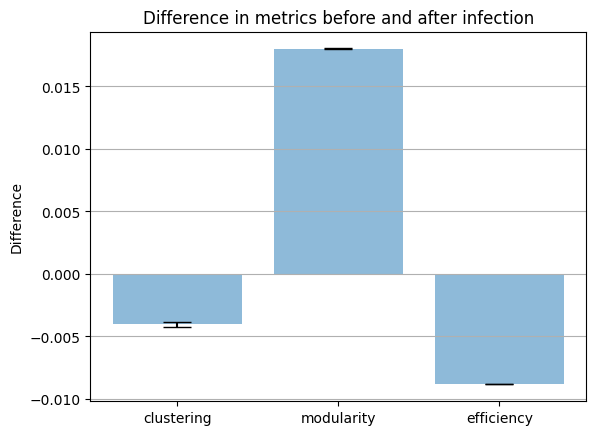

In [10]:
import matplotlib.pyplot as plt

mean_clustering = sum(differences['clustering']) / num_experiments
mean_modularity = sum(differences['modularity']) / num_experiments
mean_efficiency = sum(differences['efficiency']) / num_experiments

std_clustering = sum([(diff - mean_clustering) ** 2 for diff in differences['clustering']]) / num_experiments
std_modularity = sum([(diff - mean_modularity) ** 2 for diff in differences['modularity']]) / num_experiments
std_efficiency = sum([(diff - mean_efficiency) ** 2 for diff in differences['efficiency']]) / num_experiments
# Plotting
labels = list(differences.keys())
values = list(differences.values())

fig, ax = plt.subplots()
ax.bar(labels, [mean_clustering, mean_modularity, mean_efficiency], yerr=[std_clustering, std_modularity, std_efficiency], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Difference')
ax.set_title('Difference in metrics before and after infection')
ax.yaxis.grid(True)
plt.show()

Before infection
Before results: {'average_clustering': 0.0662482107423056, 'network_efficiency': 0.9211111111111111, 'density': 0.8422222222222222, 'modularity': 9.992007221626409e-15, 'average_degree_centrality': 0.8422222222222223, 'G': <networkx.classes.graph.Graph object at 0x0000021225A3AF20>}


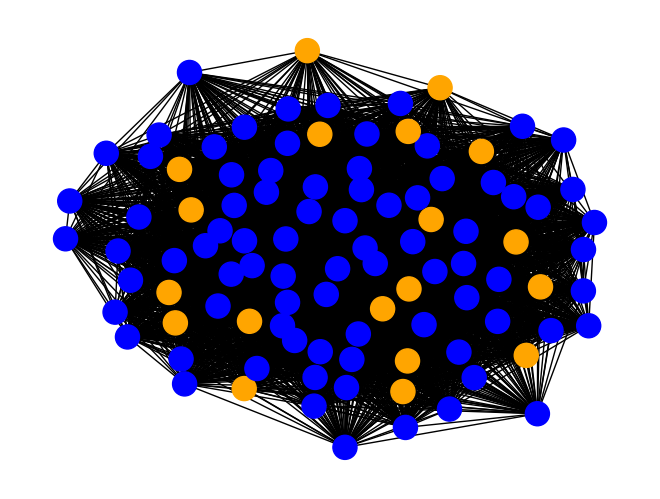

After results: {'average_clustering': 0.07066651491742064, 'network_efficiency': 0.9081818181818182, 'density': 0.8163636363636364, 'modularity': 0.017288160790900446, 'average_degree_centrality': 0.8163636363636364, 'G': <networkx.classes.graph.Graph object at 0x000002125C1705B0>}


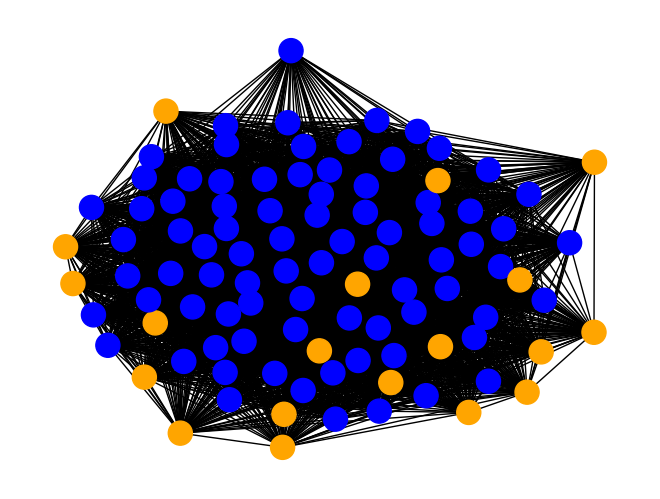

In [11]:
import networkx as nx

print("Before infection")
print("Before results:", info_before)
node_colors = ['orange' if info_before['G'].nodes[node]['infected'] else 'blue' for node in info_before['G'].nodes()]
nx.draw(info_before['G'], node_color=node_colors, with_labels=False)
plt.show()


orig_env = get_original_env(env)
info = orig_env.par_env.compute_metrics()
print("After results:", info)

node_colors = ['orange' if info['G'].nodes[node]['infected'] else 'blue' for node in info['G'].nodes()]
nx.draw(info['G'], node_color=node_colors, with_labels=False)
plt.show()

#Final results: {'average_clustering': 0.03164322941407943, 'network_efficiency': 0.6183164983164955, 'density': 0.24909090909090909, 'modularity': 0.04555648629212031, 'average_degree_centrality': 0.2490909090909091}
# Final results: {'average_clustering': 0.10277469584207866, 'network_efficiency': 0.9567676767676768, 'density': 0.9135353535353535, 'modularity': 0.0955478602252704, 'average_degree_centrality': 0.9135353535353533, 'G': 0}

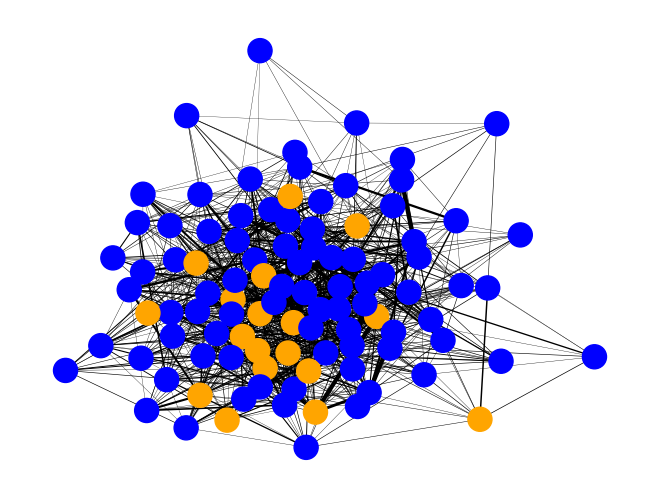

In [42]:
G_ = info['G']
node_colors = ['orange' if G_.nodes[node]['infected'] else 'blue' for node in G_.nodes()]
edges_to_remove = [(u, v) for u, v, d in G_.edges(data=True) if d.get('weight', 1) < 0.2]
G_.remove_edges_from(edges_to_remove)
nx.draw(info['G'], node_color=node_colors, with_labels=False, width=[d.get('weight', 1)**2*5 for u, v, d in G_.edges(data=True)])
plt.show()

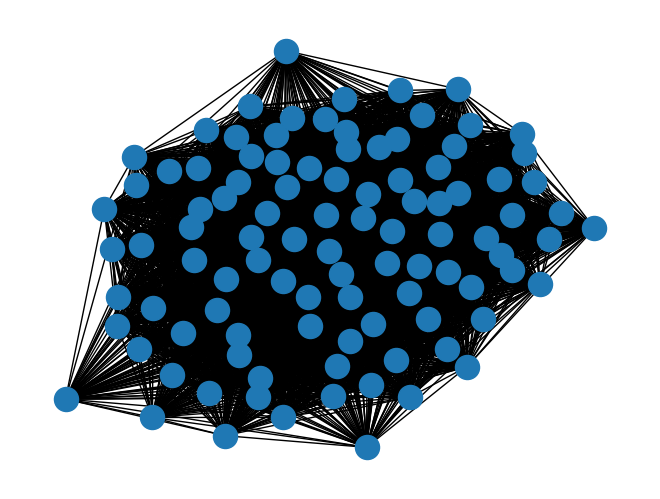

In [32]:
nx.draw(G2, with_labels=False)
plt.show()